In [22]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import time, argparse, concurrent.futures, os
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [28]:
def get_50(tlo, thi, sfr_med, sfr_pl, sfr_mn,
           nbins=22,n=1000,verbose=False,filename=''):
    ''' Read in zcmerge file '''
    tlo, thi, sfr_med, sfr_pl, sfr_mn = tlo[:nbins], thi[:nbins],\
            sfr_med[:nbins], sfr_pl[:nbins], sfr_mn[:nbins]
    tbins = 10**thi - 10**tlo
    sf_med,sf_pl,sf_mn = tbins*sfr_med, tbins*sfr_pl, tbins*sfr_mn
    sf_lo,sf_hi = sf_med-sf_mn,sf_med+sf_pl
    total_med = sf_med.sum()
    total_lo,total_hi = np.zeros(nbins),np.zeros(nbins)
    
    ''' Cumulative Star Formation (CSF) in each age bin '''
    csf_med = np.cumsum(sf_med)

    ''' N error-bars added in quadrature for N-th cumulative measure '''
    csf_hi = csf_med+np.sqrt(np.cumsum((sfr_pl*tbins)**2))
    csf_lo = csf_med-np.sqrt(np.cumsum((sfr_mn*tbins)**2))

    
    ''' Covariant Probability Distribution '''
    for i in range(nbins):
        _pl = np.sqrt(np.sum((sfr_pl*tbins)**2)-(sfr_pl[i]*tbins[i])**2)
        _mn = np.sqrt(np.sum((sfr_mn*tbins)**2)-(sfr_mn[i]*tbins[i])**2)
        corr_pl = _mn
        corr_mn = _pl
        total_hi[i] = total_med+sf_pl[i]-corr_pl
        total_lo[i] = total_med-sf_mn[i]+corr_mn
        
    sf_lo_norm, sf_med_norm, sf_hi_norm = sf_lo/total_lo,sf_med/total_med,sf_hi/total_hi
    _tmp = np.vstack((sf_lo_norm,sf_med_norm,sf_hi_norm))
    _lo,_hi = _tmp.min(axis=0),_tmp.max(axis=0); del _tmp
    err_mn,err_pl = sf_med_norm-_lo,_hi-sf_med_norm; del _lo,_hi
    csf_med_norm = np.cumsum(sf_med)/total_med
    totals   = np.hstack([total_lo,total_med,total_hi])

    '''Star formation required by best fit model uncertainties'''
    sf_1sig  = [totals.min(),totals.max()]

    ''' Generate cumulative distributions consistent with best fit model'''
    rands1 = np.random.randn(n,nbins)
    rands2 = rands1.copy()
    rands1[rands1<0],rands2[rands2>0]  = 0,0
    _err = np.array([sfr_pl*rand for rand in rands1])+np.array([sfr_mn*rand for rand in rands2])
    del rands1,rands2
    _sfr = np.array([sfr_med+err for err in _err]); del _err;
    _sfr[_sfr<0]=0
    _sf = np.array([tbins*sim for sim in _sfr]); del _sfr; 
    _totals = _sf.sum(axis=1)
    _sf1 = _sf[(_totals<sf_1sig[0]),]
    _sf2 = _sf[((_totals>=sf_1sig[0])&(_totals<=sf_1sig[1])),]
    _sf3 = _sf[(_totals>sf_1sig[1]),]; del _sf,_totals;
    _in1 = np.random.randint(low=0,high=_sf1.shape[0],size=int(np.ceil(_sf2.shape[0]/4.25)))    
    _in3 = np.random.randint(low=0,high=_sf3.shape[0],size=int(np.ceil(_sf2.shape[0]/4.25)))
    sim_sf = np.vstack((_sf1[_in1],_sf2,_sf3[_in3])); del _sf1,_sf2,_sf3,_in1,_in3
    sim_sf_norm = np.array([sf/sf.sum() for sf in sim_sf])
    sim_sf_len = sim_sf.shape[0]
    sim_csf = np.cumsum(sim_sf,axis=1); del sim_sf;
    sim_csf_norm = np.array([csf/csf[-1] for csf in sim_csf])
    sim_totals = sim_csf[:,-1]; del sim_csf;
    sim_csf_16 = np.percentile(sim_csf_norm,16,axis=0)
    sim_csf_50 = np.percentile(sim_csf_norm,50,axis=0)
    sim_csf_84 = np.percentile(sim_csf_norm,84,axis=0)
    
    ''' Determine 1-sigma distribution of age-distribution mid-point'''
    tbin_50 = []
    for csf in sim_csf_norm:
        for i in range(nbins-1):
            if ((csf[i]<0.5)&(csf[i+1]>=0.5)):
                tbin_50.append(int(i+1))
                break
        else:
            tbin_50.append(int(0))
    else:
        tbin_50 = [np.percentile(tbin_50,16,interpolation='nearest'),
               np.percentile(tbin_50,50,interpolation='nearest'),
               np.percentile(tbin_50,84,interpolation='nearest')]
        for i in range(nbins-1):
            if ((csf_med_norm[i]<0.5)&(csf_med_norm[i+1]>=0.5)):
                tbin_50.append(int(i+1))
                break
        else:
            tbin_50.append(int(0))
            
    age_likely=[10**(tlo[np.amin(tbin_50)]-6),10**(thi[np.amax(tbin_50)]-6)]
    
    ''' Highest mass of surviving stars for the most likely age range
    Isochrones from https://github.com/tristan3214/MatchExecuter/tree/master/isochrones '''
    M_max = []
    for t in tbin_50:
        t1,t2 = str(tlo[t]).replace(".", "-"),str(thi[t]).replace(".", "-")
        iso1 = pd.read_csv('isochrones/z_0-19_{:s}'.format(t1), delim_whitespace=True)
        iso2 = pd.read_csv('isochrones/z_0-19_{:s}'.format(t2), delim_whitespace=True)
        M_max.append(np.array([iso1['M_ini'].values[-1],iso2['M_ini'].values[-1]]))
    m_likely  = [np.amin(M_max).round(1),np.amax(M_max).round(1)]
    
    M_mass = []
    for t in np.hstack((tlo[0],thi[:])):
        t = str(t).replace(".", "-")
        iso = pd.read_csv('isochrones/z_0-19_{:s}'.format(t), delim_whitespace=True)
        M_mass.append(iso['M_ini'].values[-1])
    _max = np.array(M_mass[:-1])
    _min = np.array(M_mass[1:])
    
    ''' Kroupa Normalization '''
    kr_tot = (0.08**1.7 - 0.008**1.7)/1.7 + \
    (0.5**0.7 - 0.08**0.7)/0.7 + ((1/(0.5**0.3))-(1/(100**0.3)))/0.3
    '''Kroupa for ZAMS>=x '''
    kr_hi  = lambda x: ((1/(x**0.3))-(1/(100**0.3)))/\
                   ((1/(0.5**0.3))-(1/(100**0.3)))
    ''' Fraction of stellar mass put into stars with ZAMS>=x '''
    mass_frac = lambda x: kr_hi(x)/kr_tot

    ''' Maximum ZAMS progenitor mass allowed by best fit SFH model uncertainties'''
    over_min = csf_hi*mass_frac(_min)
    over_max = csf_hi*mass_frac(_max)
    allowed = ((over_max >= _max)|(over_min >= _min))
    m_allowed = [_min[allowed][0].round(1), _max[allowed][0].round(1)]
    age_allowed = [10**(tlo[allowed][0]-6), 10**(thi[allowed][0]-6)]
    
    ''' Make CDF Plot ''' 
    x = 10**(np.hstack((tlo[0],thi[:]))-6)
    xx = [(x[i]+x[i+1])/2 for i in range(len(x)-1)]
    
    y1 = np.hstack(([1],1-np.array(sim_csf_16,dtype=float)))
    y2 = np.hstack(([1],1-csf_med_norm))
    y3 = np.hstack(([1],1-np.array(sim_csf_84,dtype=float)))
    y4 = np.array([y1,y2,y3]).min(axis=0)
    y5 = np.array([y1,y2,y3]).max(axis=0)

    plt.rc("font", family='serif', weight='bold')
    plt.rc("xtick", labelsize=25); plt.rc("ytick", labelsize=25)
    
    fig, ax = plt.subplots(1,2,figsize=(24,12))
    ax[0].set_xlim(3,51); ax[0].set_ylim(-0.05,1.05)

    ax[0].plot(x,y2,'r-',label='Best Fit cumSF')
    ax[0].plot(x,y3,'g-',label='$84^{th}$ prc. cumSF')
    ax[0].plot(x,y1,'b--',label='$16^{th}$ prc. cumSF')
    ax[0].legend(loc=1, fontsize=25);

    ax[0].fill_between(x,y4,y5,color='k',alpha=0.3)
    ax[0].fill_between(age_likely,[-0.05],[1.05],color='#F5B041',alpha=0.2)
    ax[0].fill_between(age_allowed,[-0.05],[1.05],color='#8E44AD',alpha=0.2)

    ax[0].plot([-1,51],[0.84,0.84],'k:')
    ax[0].plot([-1,51],[0.5,0.5],'k:')
    ax[0].plot([-1,51],[0.16,0.16],'k:')

    ax[0].text(age_likely[1]+0.1, 0.52, 'Probable Range: ', fontsize=24, weight='bold')
    ax[0].text(age_likely[1]+0.1, 0.44, '{:.1f} - {:.1f} M$_\odot$'.format(m_likely[0],m_likely[1]),
            fontsize=28, weight='bold')
    
    ax[0].text(4, 0.32, 'Maximum Allowed: ', fontsize=24, weight='bold')
    ax[0].text(4, 0.24, '{:.1f} - {:.1f} M$_\odot$'.format(m_allowed[0],m_allowed[1]),
            fontsize=28, weight='bold')

    ax[0].set_xlabel('Age (Myr)', fontsize=25, weight='bold')
    ax[0].set_ylabel('Cumulative Stellar Mass Fraction', fontsize=25,weight='bold')
    ax[0].set_title('Probability of Core-Collapse Progenitor Age',fontsize=25,weight='bold')
    
    ax[1].set_xlim(3,51)
    ax[1].set_ylim(0,sfr_med.max()*1e6+sfr_pl.max()*1e6+100)

    ax[1].step(x,np.hstack((0,sfr_med[:22]*1e6)),linewidth=3)
    ax[1].errorbar(xx,sfr_med*1e6,yerr=[sfr_mn*1e6,sfr_pl*1e6],fmt='none',linewidth=3)

    ax[1].set_xlabel('Age (Myr)', fontsize=25, weight='bold')
    ax[1].set_ylabel('Star Formation Rate (M$_{\odot}$ / Myr)', fontsize=25,weight='bold')
    ax[1].set_title('Star Formation History',fontsize=25,weight='bold')
 
    #plt.savefig(filename+'_CDF.png')
    plt.show()
    plt.close('all')

    
    ''' Summary '''
    if verbose:
        totals = np.hstack([total_lo,total_hi])
        _t = [totals.min(),total_med,totals.max()]

        print('\n\n***** Filename: {:s} *****\n'.format(str(filename)))
        
        print('\n === Error Propagation ===\n\n1-Sigma required Star Formation (M_sun)')
        [print('{:d}'.format(int(_t[i].round()))) for i in range(3)]

        print('\n === Random Sampling: Accepted {:d}/{:d}==='
              .format(int(sim_sf_len),int(n)))
            
        mid68_sf = [float(np.percentile(sim_totals,16)),
                    float(np.percentile(sim_totals,50)),
                    float(np.percentile(sim_totals,84))]

        print('\n50th Mid-68 Star Formation (M_sun)')
        [print('{:d}'.format(int(np.round(mid68_sf[i])))) for i in range(3)]
 
        print('\n50th Mid-68 Age Bins (log(t))')
        [print('{:.2f} - {:.2f}'.format(tlo[tbin_50[i]], thi[tbin_50[i]])) for i in range(3)]
    
        print('\n50th Mid-68 Max ZAMS (M_sun)')
        [print('{:.1f} - {:.1f}'.format(M_max[i][1], M_max[i][0])) for i in range(3)]
 
        print('\n\nProbable Mass Range:\n{:.1f} - {:.1f} solar masses'.format(m_likely[0],m_likely[1]))
        print('\nProbable Age Range:\n{:.1f} - {:.1f} Myr'.format(age_likely[0],age_likely[1]))
        
        print('\nMaximum Mass Range:\n{:.1f} - {:.1f} solar masses'.format(m_allowed[0],m_allowed[1]))
        print('\nMinimum Age Range:\n{:.1f} - {:.1f} Myr\n\n'.format(age_allowed[0],age_allowed[1]))

    ''' Table of Probability Distribution '''
    data = np.array([['{:.1f}'.format(float(10**(tlo[i]-6))),
                      '{:.1f}'.format(float(10**(thi[i]-6))),
                      '{:.4e}'.format(float(sfr_med[i])),
                      '{:.4e}'.format(float(sfr_mn[i])),
                      '{:.4e}'.format(float(sfr_pl[i])),
                      '{:.3f}'.format(float(sf_med_norm[i])),
                      '{:.3f}'.format(float(err_mn[i])),
                      '{:.3f}'.format(float(err_pl[i])),
                      '{:.3f}'.format(float(csf_med_norm[i])),
                      '{:.3f}'.format(float(sim_csf_16[i])),
                      '{:.3f}'.format(float(sim_csf_50[i])),
                      '{:.3f}'.format(float(sim_csf_84[i])),
                      '{:.1f}'.format(float(_min[i])),
                      '{:.1f}'.format(float(_max[i]))]
                     for i in range(nbins)])
    return pd.DataFrame(data,columns=['T1','T2',
                          'SFR (Best)','-err','+err',
                          '  PDF(Best)','-err','+err',
                          '  CDF(Best)',' CDF(16)','CDF(50)','CDF(84)',
                                      '     M1','  M2'])

'''Argument parser '''
def parse_all():
    parser = argparse.ArgumentParser()
    parser.add_argument('filenames', nargs='+',help='Photomtery file names')
    parser.add_argument('--NRAND', '-n', type=int, dest='n', default=100000, help='Random Sample Count')
    parser.add_argument('--NBINS', '-nbins', type=int, dest='nbins', default=22, help='# of youngest age bins to keep')
    parser.add_argument('--SILENT', '-silent', dest='silent', default=False, action='store_true', help='Talkative?')
    parser.add_argument('--LATEX', '-latex', dest='latex', default=False, action='store_true', help='Produce Table?')
    return parser.parse_args()


In [29]:
def DoAll(filename,fid,nbins=22,n=1000000,verbose=False,latex=False):
    tlo,thi,sfr_med,sfr_pl,sfr_mn = np.loadtxt(filename, 
        usecols=[0, 1, 3, 4, 5], unpack=True, skiprows=1)
    pdf = get_50(tlo, thi, sfr_med, sfr_pl, sfr_mn, nbins, n, verbose, fid)
    if latex: pdf.to_latex(open(fid+'.tex','w'),index=False)
    return

In [30]:
plt.close('all')

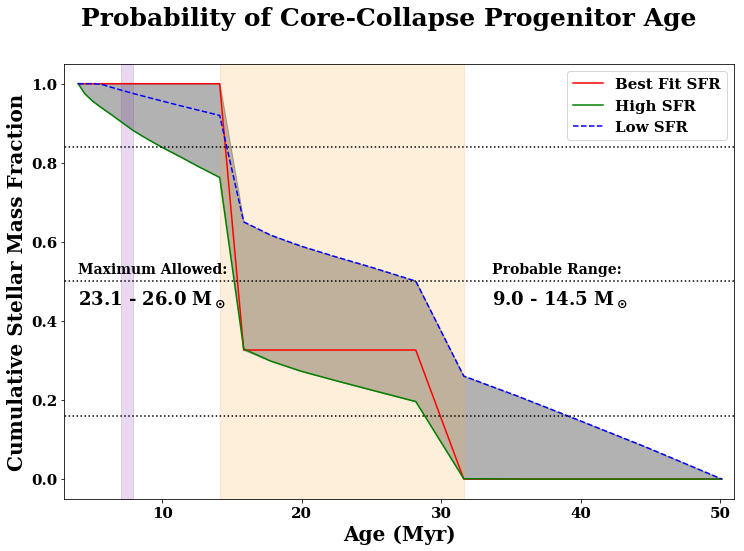


 === Error Propagation ===

1-Sigma required Star Formation (M_sun)
6979
6979
8005

 === Random Sampling: Accepted 45829/1000000===

50th Mid-68 Star Formation (M_sun)
6979
7570
8005

50th Mid-68 Age Bins (log(t))
7.15 - 7.20
7.15 - 7.20
7.45 - 7.50

50th Mid-68 Max ZAMS (M_sun)
13.4 - 14.5
13.4 - 14.5
9.0 - 9.6


Probable Mass Range:
9.0 - 14.5 solar masses

Probable Age Range:
14.1 - 31.6 Myr

Maximum Mass Range:
23.1 - 26.0 solar masses

Minimum Age Range:
7.1 - 7.9 Myr


***** Filename: fit_gst311b.err *****
 
 %=== Probability Distribution ===
 \begin{tabular}{lllllllllll}
\toprule
T1(Myr) & T2(Myr) & P(Best) &   +err &   -err &     P(Lo) &  P(Hi) & CDF(Best) & PDF(16) & PDF(50) & PDF(84) \\
\midrule
    4.0 &     4.5 &   0.000 &  0.033 &  0.000 &     0.000 &  0.033 &     0.000 &   0.000 &   0.000 &   0.026 \\
    4.5 &     5.0 &   0.000 &  0.033 &  0.000 &     0.000 &  0.033 &     0.000 &   0.000 &   0.000 &   0.026 \\
    5.0 &     5.6 &   0.000 &  0.034 &  0.000 &     0.000 & 

In [31]:
DoAll('fit_gst311b.err','fit_gst311b.err',n=1000000,verbose=True,latex=True)